# CSCI-UA 0473 - Introduction to Machine Learning
## Homework 2
### Adaptive RBFN and Stochastic Gradient Descent (25 Points)

The task for this homework is again that of handwritten digit recognition on the MNIST dataset.  **For this time, you will train on the full dataset (that is, 60000 training images plus 10000 test images), rather than a small subset.**

Your first goal is to implement an adaptive radial basis function network, and train it with stochastic gradient descent (SGD), while going over a few questions.

<div class="alert alert-danger">
**Please do not miss any text with red background; they are either questions you need to answer, or directions to implement some functionality.**
</div>

<div class="alert alert-warning">
**Please start this homework early.**  Stochastic gradient descent will take a particularly long time to train.
</div>

<div class="alert alert-warning">
**Please submit a fully-run notebook; not doing so would incur at least 10% penalty problem-wise.**
</div>

In [1]:
import autograd.numpy as np
import autograd.scipy as ascipy
import autograd.misc.flatten
from autograd import value_and_grad
import scipy.optimize
import pickle
from sklearn import datasets

import matplotlib.pyplot as plot

%matplotlib inline

## 1. Data

In [2]:
npz = np.load('mnist.npz')

train_labels = npz['train_labels']
test_labels = npz['test_labels']

# Apply scaling from 0-255 to 0-1
train_data = npz['train_data'] / 255.
test_data = npz['test_data'] / 255.

The shapes and types for each numpy array is:

* `train_data`: $60000 \times 28 \times 28$ *float64* array
* `train_labels`: $60000$ *int64* array
* `test_data`: $10000 \times 28 \times 28$ *float64* array
* `test_labels`: $10000$ *int64* array

The digit for i-th training data (`train_data[i]`) is `train_labels[i]`.  The same holds for test data.

Text(0.5, 1.05, 'Digit 5')

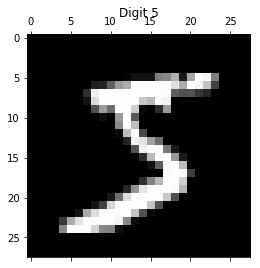

In [3]:
plot.matshow(train_data[0], vmin=0, vmax=1, cmap='gray')
plot.title('Digit {}'.format(train_labels[0]))

## 2. Model Definition

The first thing we need is model definition.  Recall that the Gaussian Radial Basis Function we have learned in the class transforms an arbitrary input vector $\mathbf{x} \in \mathbb{R}^d$ into another vector $\phi(\mathbf{x}) \in \mathbb{R}^k$ based on a set of bases $\mathbf{r}_k$:

$$
\phi(\mathbf{x})_k = \exp\left(-\lVert \mathbf{x} - \mathbf{r}_k \rVert^2\right) = \exp \left(- \sum_{i=1}^d (x_i - r_{ki})^2\right)
$$

An alternative would be taking an average of the squares instead of summing them up:

$$
\phi(\mathbf{x})_k = \exp\left(-\lVert \mathbf{x} - \mathbf{r}_k \rVert^2\right) = \exp \left(- \dfrac{1}{d} \sum_{i=1}^d (x_i - r_{ki})^2\right)
$$

<div class="alert alert-danger">
(5 points) Between the two options, which one do you think that would work better?  Justify your answer and replace the `XXX` in the `adaptive_rbfn_logits` function with your choice.  **Note: "by experiment" is not a sufficient justification for *this* problem.**
</div>

Answer: I think the second one works better.
Because it is good to have a "scaling factor".

As the scaling factor d -> 0, the whole thing is amplified. Consider the graph of this function: d defines the region between "intersection" of the graph and x-axis, call it distance. We can find d such that any example that is outside the distance has a weight of 0. That is to say, as d->0,  $$ \left(- \dfrac{1}{d} \sum_{i=1}^d (x_i - r_{ki})^2\right)$$ is considerable only for the very close example, such that we almost consider nearest example.

We can take the class label of the majority with respect to the weight. We look at positive example, examine how close it is to the new input, and look at the negative example. Very far input example x will have very little contribution.

In [4]:
def adaptive_rbfn_logits(x, params):
    '''
    x: numpy array of training data, with shape (n_samples, 28, 28)
    params: a dictionary with "bases", "w" and "b" as keys.
    '''
    bases = params['bases']
    w = params['w']
    b = params['b']
    x = x.reshape((x.shape[0], -1))
    
    phi = np.exp(-((x[:, None, :] - bases[None, :, :]) ** 2).sum(axis=-1) / x.shape[1]) # (n_samples, n_bases)
    logits = np.dot(phi, w) + b
    
    return logits

The function above applies a linear transformation on $\phi(\mathbf{x})$ to get the *logits* for each class.  The logits can be considered as "scores"; the higher the logit, the more likely the class.  In fact, the probability of a certain class can be directly computed by applying a *softmax* on the logits.

Recall that the multiclass logistic regression minimizes the negative log-likelihood (sometimes also called *cross entropy*) of the entire dataset:

$$
J(M, D_\text{tra}) = -\dfrac{1}{N} \sum_{(\mathbf{x}, y^*) \in D_\text{tra}}
\log \dfrac{\exp \mathbf{w}^T_{y^*} \tilde{\mathbf{x}}}{\sum_y \exp \mathbf{w}^T_y \tilde{\mathbf{x}}}
$$

<div class="alert alert-danger">
(5 points) The following function implements the cost function in a naive, numerically unstable way.  Please rewrite the indicated block **in at most 2 lines** so that it becomes numerically stable.  You will only get 2 points if your replacement is correct and more than 2 lines.
</div>

<div class="alert alert-info">
**Hint:** See `autograd.scipy.misc` for how we select elements efficiently (which is usually called <a href='https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays'>fancy</a> <a href='https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays'>indexing</a>). <br/>

Other auto-differentiation frameworks also have their numerically stable log-softmax functions.
</div>

In [5]:
def adaptive_rbfn_cost(param_buf, x, y, unpack):
    '''
    The cost function for ARBFN.
    x: numpy array of training data, with shape (n_samples, 28, 28)
    y: numpy array of training labels, with shape (n_samples,).  All elements are integers.
    param_buf: the *flattened* numpy array containing all the parameters.
    unpack: a function that recovers the flattened parameters into the original list/dict.
    
    param_buf and unpack are quite a nuisance as they are introduced by autograd.
    A more detailed explanation comes with the "autograd.misc.flatten" function below.
    '''
    params = unpack(param_buf)
    logits = adaptive_rbfn_logits(x, params)
    
    #### BEGINNING OF CODE TO BE REPLACED
    log_probs = (logits - ascipy.misc.logsumexp(logits, axis=1, keepdims=True))[np.arange(x.shape[0]), y]
    cost = -log_probs.mean()
    #exp_logits = np.exp(logits)
    #softmax = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    #log_probs = np.log(softmax[np.arange(x.shape[0]), y])
    #cost = -log_probs.mean()
    #### END OF CODE TO BE REPLACED
    
    return cost

In [6]:
# This statement returns a function that has the same signature as adaptive_rbfn_cost(),
# but returns both the cost and the gradient.
adaptive_rbfn_cost_and_grad = value_and_grad(adaptive_rbfn_cost)

In [7]:
def train_full_batch(cost_and_grad, initial_params, train_data, train_labels, use_scipy=True, learning_rate=1, max_iter=30000):
    # NOTE: We should have early stopping here, but it is left for you to implement in the next problem (not here).
    # Autograd.misc.flatten() is a tricky function that allows us to compute the gradients to all parameters
    # with a single grad() call.
    # It takes in a list or dictionary, and returns two objects:
    # (1) a flattened, i.e. 1D, numpy array which contains all the parameters, and
    # (2) an unflatten function, which will recover the original list/dictionary structure from the flattened array.
    # Collapsing all the parameters into a single array would also allow us to use scipy's optimize function which
    # only takes one input variable.
    param_buf, unpack = autograd.misc.flatten(initial_params)

    if not use_scipy:
        for i in range(max_iter):
            loss, dparam_buf = cost_and_grad(param_buf, train_data, train_labels, unpack)
            param_buf -= learning_rate * dparam_buf
            if i % 100 == 0:
                print(i, loss)
    else:
        model = scipy.optimize.minimize(cost_and_grad, param_buf, (train_data, train_labels, unpack), jac=True, method='CG')
        print(model)
        param_buf = model.x
    
    return unpack(param_buf)

Now that we have defined a function for training an adaptive RBFN, let's see how a small model works on a small dataset (100 training samples, 10 test samples).

In [8]:
train_size = 100
test_size = 10
n_bases = 10
n_features = np.prod(train_data.shape[1:])

params = {}
params['bases'] = np.random.rand(n_bases, n_features)
params['w'] = np.random.randn(n_bases, 10) * 0.1
params['b'] = np.zeros(10)

In [9]:
%%time
new_params = train_full_batch(adaptive_rbfn_cost_and_grad, params, train_data[:train_size], train_labels[:train_size], False)

C:\Users\kz882\Anaconda3\lib\site-packages\autograd\numpy\numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
C:\Users\kz882\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  onp.add.at(A, idx, x)


0 2.3132198612747286
100 2.2621100851870013
200 2.2615907273048923
300 2.2610309665720454
400 2.2604090883692205
500 2.2596996866178465
600 2.2588720524359287
700 2.2578881916474556
800 2.2567003394029608
900 2.25524781767129
1000 2.253453060321034
1100 2.2512166196510544
1200 2.248410984238369
1300 2.2448731109205404
1400 2.240395754747368


KeyboardInterrupt: 

In [31]:
y_hat = adaptive_rbfn_logits(test_data[:test_size], new_params).argmax(axis=1)
print(np.equal(y_hat, test_labels[:test_size]).sum(), '/', test_size)

NameError: name 'new_params' is not defined

When the gradient is computed from the entire training set, we usually call it *(full) batch gradient descent*.  However, batch gradient descent is time- and memory-consuming, in the sense that it has to go through all the training examples and average all the gradients for a *single* step, and it quickly becomes impractical if the dataset or the model becomes large.

The solution is *not* to see all the examples for a single gradient step.  Instead, for each step, we compute and average the gradients for only a small subset (commonly called a *minibatch*) of examples.  This is called *minibatch gradient descent*, or *stochastic gradient descent* (SGD), though the latter refer to the special case where the minibatch only contains a single example in some literatures.

The intuition behind SGD is that the minibatch gradient is a noisy but unbiased estimate of the true gradient.  This of course has pros and cons.

The main downside is that, due to the inherent noise of minibatch gradient, SGD no longer guarantees to converge to a local minimum, and sometimes it will fluctuates or even overshoot itself.  You will have to use a significantly smaller, and sometimes decaying, learning rate.  Very often, you would see a curve of training loss like [this](http://cs231n.github.io/neural-networks-3/#loss):

![](http://cs231n.github.io/assets/nn3/loss.jpeg)

The obvious upside is that estimating the gradient using minibatch is much more efficient than computing the true gradient across all training examples.  Or, after we iterate over the entire training set, we had already performed a lot of gradient steps, which is not necessarily a bad thing.  In fact, the size of a minibatch itself can be considered as a hyperparameter to fiddle with.

In practice, SGD often works good enough, especially for large models (such as neural networks) on large datasets.

See [Leon Bottou's SGD Tricks](https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf) if you are interested in the details of SGD.

<div class="alert alert-danger">
(15 points) Implement SGD, and train your ARBFN model with 20 bases (or any number you like) on the whole dataset, with the size of minibatch being 10.  <br/>
Plot the training loss and validation accuracy, and report the test accuracy.  **Your implementation should have a test accuracy above 80% to be considered correct.** <br/>
Do the same for minibatch size 100 and answer this question in the cell below: *What do you observe from the learning curve and training time of different minibatch sizes?*  <br/>

You are free to define your own `train_sgd` function.  **Please do not use `autograd.misc.optimizers` package.**
</div>

<div class="alert alert-info">
**Hint:** To save your time figuring out the complete workflow of SGD, here is how we usually do it.
<ol>
    <li> Split the training set into a validation set and another smaller training set. </li>
    <li> Shuffle the (rest of the) training set. Of course, you can shuffle the indices rather than the actual items. </li>
    <li> Divide the training set into equally-sized minibatches.  The last batch may not have the same size as the others, and it's up to you how to deal with it (usually it doesn't matter too much). </li>
    <li> Iterate over each minibatch, compute the gradient, and update the parameters. </li>
    <li> After going through all the minibatches (we call that *an epoch*), evaluate the model on validation set, and decide whether to early stop.  Since SGD will fluctuate a lot, you may want to leave it run for a little while longer even if the validation error does not seem to decrease.  </li>
    <li> Repeat 2-5 until done. </li>
</ol>

Optionally, you can also decay the learning rate after each minibatch or each epoch.
</div>

<div class="alert alert-warning">
**Warning:** This assignment would take potentially hours to train a model to "good performance" on an average laptop.  In practice, it is very common for neural networks to take hours, days or even weeks to train, even if powered by GPUs which are good at matrix multiplication and elementwise computation.
</div>

Answer: SGD with smaller batch size are faster to converge but has more noises and is less stable. The observations are reasonable as SGD with smaller batch size updates after processing a smaller subset; SGD with larger batch size updates at a smaller pace.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)


In [33]:
n_bases = 20
n_features = np.prod(train_data.shape[1:])

params = {}
params['bases'] = np.random.rand(n_bases, n_features)
params['w'] = np.random.randn(n_bases, 10) * 0.1
params['b'] = np.zeros(10)

In [34]:
# YOUR CODE HERE
def train_sgd(cost_and_grad, initial_params, train_data, train_labels, val_data, val_labels, batch_size, learning_rate, max_epoch):
    param_buf, unpack = autograd.misc.flatten(initial_params)
    
    # threshold for recording loss history
    threshold = 100
    if batch_size == 10:
        threshold = 800
    if batch_size == 100:
        threshold = 80
    
    # setting for early stopping
    best_param_buf = None
    best_val_acc = 0
    fluctuate_threshold = 3
    
    for epoch in range(max_epoch):
        
        # randomly shuffle data
        random_idxs = np.random.choice(train_data.shape[0], train_data.shape[0], replace=False)
        X_shuffled = train_data[random_idxs, :, :]
        y_shuffled = train_labels[random_idxs]
        
        for i in range(0, X_shuffled.shape[0], batch_size):
            loss, dparam_buf = cost_and_grad(param_buf, X_shuffled[i : i + batch_size], y_shuffled[i : i + batch_size], unpack)
            if i % threshold == 0:
                loss_hist.append(loss)
            
            param_buf -= learning_rate * dparam_buf
        
        # evaluate the model on validation set
        y_hat = adaptive_rbfn_logits(val_data, unpack(param_buf)).argmax(axis=1)
        val_acc = np.equal(y_hat, val_labels).sum() / val_data.shape[0]
        val_acc_hist.append(val_acc)
        print("epoch {}, loss {:.5f}, val_acc {:.5f}".format(epoch, loss, val_acc))
            
        # decide whether to early stop
        if val_acc > best_val_acc:
            stopping_step = 0
            best_val_acc = val_acc
            best_param_buf = param_buf.copy()
        else:
            stopping_step += 1
        if stopping_step > fluctuate_threshold:
            print("Early stopping triggered at epoch {}".format(epoch))
            break
        
    return unpack(best_param_buf)

In [35]:
loss_hist = []
val_acc_hist = []

In [36]:

%%time
new_params = train_sgd(adaptive_rbfn_cost_and_grad, params, X_train, y_train, X_val, y_val,batch_size=10, learning_rate=1, max_epoch=100)

C:\Users\kz882\Anaconda3\lib\site-packages\autograd\numpy\numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
C:\Users\kz882\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  onp.add.at(A, idx, x)
C:\Users\kz882\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

epoch 0, loss 1.85939, val_acc 0.37525
epoch 1, loss 0.74292, val_acc 0.69533
epoch 2, loss 0.56553, val_acc 0.80083
epoch 3, loss 0.22520, val_acc 0.85358
epoch 4, loss 0.81279, val_acc 0.84317
epoch 5, loss 0.28559, val_acc 0.86600
epoch 6, loss 0.29784, val_acc 0.88567
epoch 7, loss 0.40994, val_acc 0.87792
epoch 8, loss 0.22744, val_acc 0.88642
epoch 9, loss 1.61816, val_acc 0.87683
epoch 10, loss 0.19780, val_acc 0.89875
epoch 11, loss 0.26193, val_acc 0.90242
epoch 12, loss 0.08959, val_acc 0.90408
epoch 13, loss 0.57784, val_acc 0.89625
epoch 14, loss 0.05810, val_acc 0.90958
epoch 15, loss 0.78661, val_acc 0.90000
epoch 16, loss 0.71496, val_acc 0.89783
epoch 17, loss 0.36337, val_acc 0.91125
epoch 18, loss 0.79829, val_acc 0.90908
epoch 19, loss 1.25532, val_acc 0.89658
epoch 20, loss 0.08567, val_acc 0.90792
epoch 21, loss 0.52795, val_acc 0.90342
Early stopping triggered at epoch 21
Wall time: 31min 1s


In [38]:
y_hat = adaptive_rbfn_logits(test_data, new_params).argmax(axis=1)
test_acc = np.equal(y_hat, test_labels).sum() / test_data.shape[0]
print("Test Accuracy: {}".format(test_acc))

Test Accuracy: 0.9098


<Figure size 432x288 with 0 Axes>

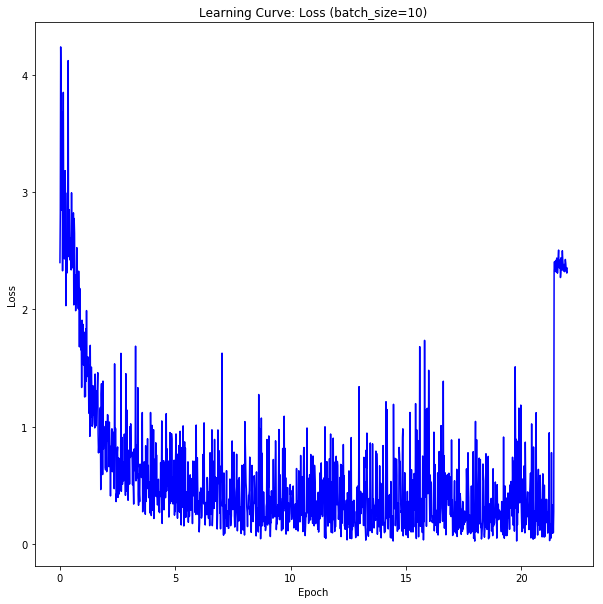

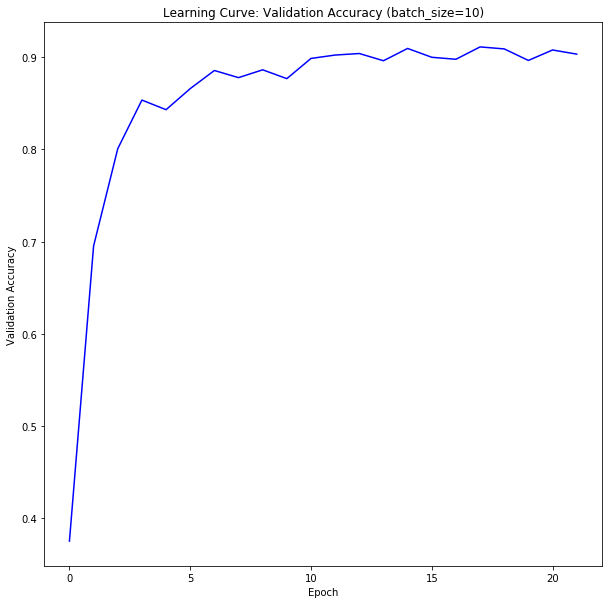

In [39]:
epoch = len(val_acc_hist)
batch_size = 100

plot.figure(1)
plot.figure(figsize=(10,10))
plot.title("Learning Curve: Loss (batch_size=10)")
plot.xlabel("Epoch")
plot.ylabel("Loss")
plot.plot(np.linspace(0, epoch, len(loss_hist), endpoint=True), loss_hist, 'b')

plot.figure(2)
plot.figure(figsize=(10,10))
plot.title("Learning Curve: Validation Accuracy (batch_size=10)")
plot.xlabel("Epoch")
plot.ylabel("Validation Accuracy")
plot.plot(range(epoch), val_acc_hist, 'b')

In [52]:
loss_hist = []
val_acc_hist = []

In [53]:
%%time
new_params = train_sgd(adaptive_rbfn_cost_and_grad, params, X_train, y_train, X_val, y_val,batch_size=100, learning_rate=1, max_epoch=100)

IndexError: too many indices for array

In [50]:
y_hat = adaptive_rbfn_logits(test_data, new_params).argmax(axis=1)
test_acc = np.equal(y_hat, test_labels).sum() / test_data.shape[0]
print("Test Accuracy: {}".format(test_acc))

Test Accuracy: 0.9098


<Figure size 432x288 with 0 Axes>

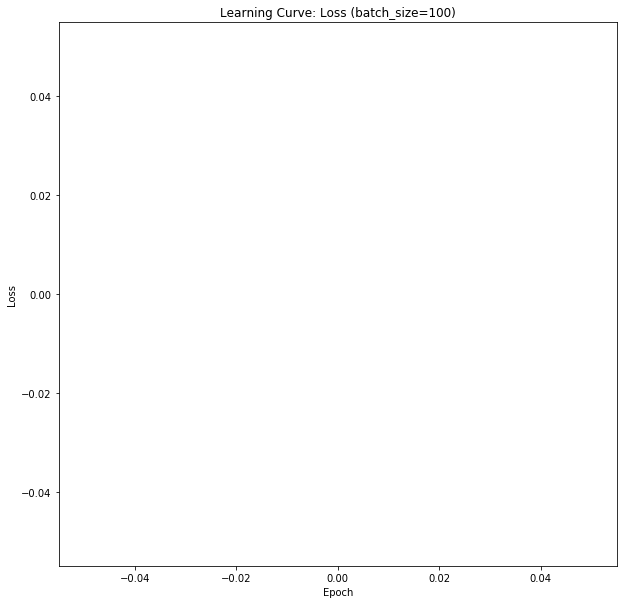

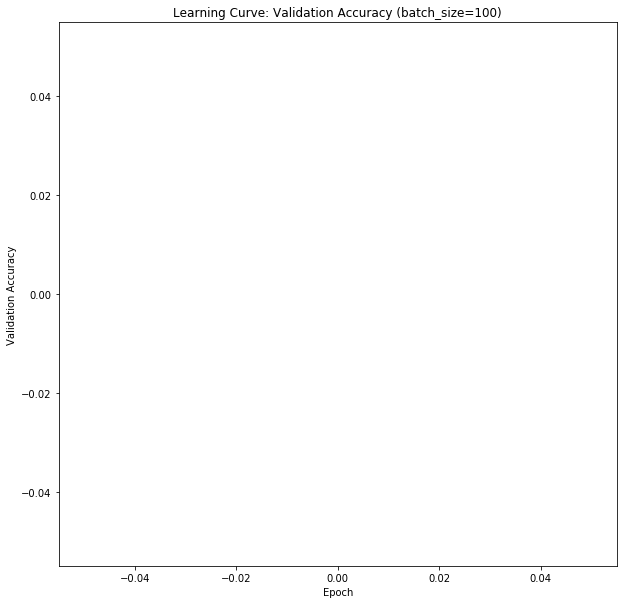

In [51]:
epoch = len(val_acc_hist)
batch_size = 100

plot.figure(1)
plot.figure(figsize=(10,10))
plot.title("Learning Curve: Loss (batch_size=100)")
plot.xlabel("Epoch")
plot.ylabel("Loss")
plot.plot(np.linspace(0, epoch, len(loss_hist), endpoint=True), loss_hist, 'b')

plot.figure(2)
plot.figure(figsize=(10,10))
plot.title("Learning Curve: Validation Accuracy (batch_size=100)")
plot.xlabel("Epoch")
plot.ylabel("Validation Accuracy")
plot.plot(range(epoch), val_acc_hist, 'b')

For reference, here is our training loss and validation accuracy curve running for 2000 epochs.  Your training and validation curve does *not* need to look like ours; this is only supposed to give you a rough idea of how the curves would look like.

![](curve.png)

### Assignment 5: k-NN Classifier (15 points)

The second goal is to compare you ARBFN against a k-NN classifier.  For the k-NN classifier, you need to try a couple $k$'s and pick the best one in a programmatic way.

<div class="alert alert-danger">
(15 points) Build a k-NN classifier using `scikit-learn` with $k$'s from 1 to 3, train it on the first 1000 examples of MNIST dataset, and report the accuracy on the full test set. <br/>

Would you use the (exact) k-NN classifier you have built for very large dataset (with maybe millions of examples)?  Explain your answer.
</div>

In [40]:
# YOUR CODE HERE
from sklearn.neighbors import KNeighborsClassifier

# train it on the first 1000 examples of MNIST dataset, and report the accuracy on the full test set
X_train = train_data[0:1000, :, :].reshape(1000, -1)
y_train = train_labels[0:1000]
X_test = test_data.reshape(test_data.shape[0], -1)
y_test = test_labels

for k in [1, 2, 3]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print("k = {}, Test accuracy: {:.5f}%".format(k, score * 100))

k = 1, Test accuracy: 86.90000%
k = 2, Test accuracy: 84.96000%
k = 3, Test accuracy: 86.22000%


Answer: I would not use K-NN classifier for very large data set. Since the distance between each training sample for each model have to be computed, the amount of computation would be huge. 